[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# The g-h Filter

In [1]:
#format the book
%matplotlib inline
from __future__ import division, print_function
import matplotlib.pyplot as plt
import book_format
book_format.load_style()

## Building Intuition via Thought Experiments

Imagine that we live in a world without scales - the devices you stand on to weigh yourself. One day at work a coworker comes running up to you and announces her invention of a 'scale' to you. After she explains, you eagerly stand on it and announce the results: "172 lbs". You are ecstatic - for the first time in your life you know what you weigh. More importantly, dollar signs dance in your eyes as you imagine selling this device to weight loss clinics across the world! This is fantastic!

Another coworker hears the commotion and comes over to find out what has you so excited. You explain the invention and once again step onto the scale, and proudly proclaim the result: "161 lbs." And then you hesitate, confused.

"It read 172 lbs just a few seconds ago" you complain to your coworker. 

"I never said it was accurate," she replies.

Sensors are inaccurate. This is the motivation behind a huge body of work in filtering, and solving this problem is the topic of this book. I could just provide the solutions that have been developed over the last half century, but these solutions developed by asking very basic, fundamental questions into the nature of what we know and how we know it. Before we attempt the math, let's follow that journey of discovery, and see if it does not inform our intuition about filtering. 

** Try Another Scale**

Is there any way we can improve upon this result? The obvious, first thing to try is get a better sensor. Unfortunately, your co-worker informs you that she has built 10 scales, and they all operate with about the same accuracy. You have her bring out another scale, and you weigh yourself on one, and then on the other. The first scale (A) reads "160 lbs", and the second (B) reads "170 lbs". What can we conclude about your weight?

Well, what are our choices?

* We could choose to only believe A, and assign 160lbs to our weight estimate. 
* we could choose to only believe B, and assign 170lbs to our weight.
* We could choose a number less than either A or B
* We could choose a number greater than either A or B
* We could choose a number between A and B

The first two choices are plausible, but we have no reason to favor one scale over the other. Why would we choose to believe A instead of B? We have no reason for such a belief. The third and fourth choices are irrational. The scales are admittedly not very accurate, but there is no reason at all to choose a number outside of the range of what they both measured. The final choice is the only reasonable one. If both scales are inaccurate, and as likely to give a result above my actual weight as below it, more often than not probably the answer is somewhere between A and B. 

In mathematics this concept is formalized as *expected value*, and we will cover it in depth later. For now ask yourself what would be the 'usual' thing to happen if we made one million separate readings. Some of the times both scales will read too low, sometimes both will read too high, and the rest of the time they will straddle the actual weight. If they straddle the actual weight then certainly we should choose a number between A and B. If they don't straddle then we don't know if they are both too high or low, but by choosing a number between A and B we at least mitigate the effect of the worst measurement. For example, suppose our actual weight is 180 lbs. 160 lbs is a big error. But if we choose a weight between 160 lbs and 170 lbs our estimate will be better than 160 lbs. The same argument holds if both scales returned a value greater than the actual weight.

We will deal with this more formally later, but for now I hope it is clear that our best estimate is just the average of A and B. $\frac{160+170}{2} = 165$.

We can look at this graphically. I have plotted the measurements of A and B with an assumed error of $\pm$ 8 lbs. The overlap falls between 160 and 170 so the only weight that makes sense must lie within 160 and 170 pounds.

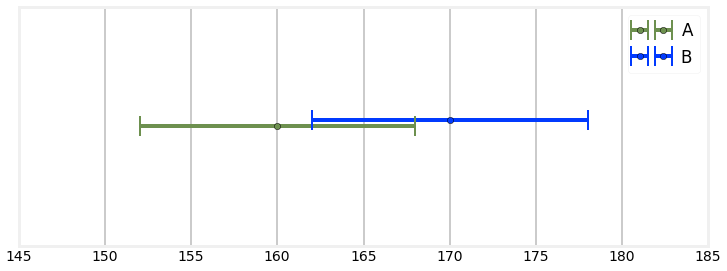

In [2]:
plt.errorbar([160], [1], xerr=8, fmt='o', label='A', capthick=2, capsize=10)
plt.errorbar([170], [1.05], xerr=8, fmt='o', label='B', capthick=2, capsize=10)
plt.ylim(0, 2)
plt.xlim(145, 185)
plt.legend()
plt.gca().axes.yaxis.set_ticks([])
plt.show()

So 165 lbs looks like a reasonable estimate, but there is more information here that we might be able to take advantage of. The only weights that are possible lie in the intersection between the error bars of A and B. For example, a weight of 161 lbs is impossible because scale B could not give a reading of 170 lbs with a maximum error of 8 pounds. Likewise a weight of 171 lbs is impossible because scale A could not give a reading of 160 lbs with a maximum error of 8 lbs. In this example the only possible weights lie in the range of 162 to 168 lbs.

That doesn't yet allow us to find a better weight estimate, but let's play 'what if' some more. What if we are now told that A is three times more accurate than B? Consider the 5 options we listed above. It still makes no sense to choose a number outside the range of A and B, so we will not consider those. It perhaps seems more compelling to choose A as our estimate - after all, we know it is more accurate, why not just use it instead of B? Can B possibly improve our knowledge over A alone?

The answer, perhaps counter intuitively, is yes, it can. First, let's look at the same measurements of A=160 and B=170, but with the error of A $\pm$ 3 lbs and the error of B is 3 times as much, $\pm$ 9 lbs.

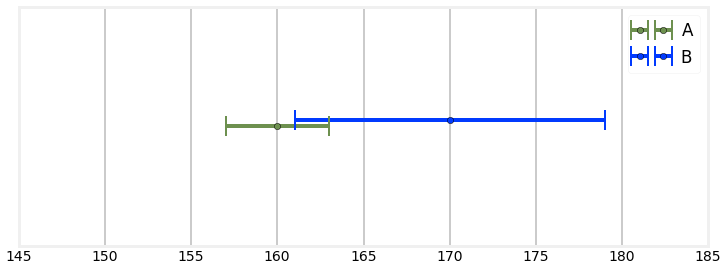

In [3]:
plt.errorbar([160], [1], xerr=3, fmt='o', label='A', capthick=2, capsize=10)
plt.errorbar([170], [1.05], xerr=3*3, fmt='o', label='B', capthick=2, capsize=10)
plt.ylim(0, 2)
plt.xlim(145, 185)
plt.legend()
plt.gca().axes.yaxis.set_ticks([])
plt.show()

The overlap of the error bars of A and B are the only possible true weight. This overlap is smaller than the error in A alone. More importantly, in this case we can see that the overlap doesn't include 160 lbs or 165 lbs. If we only used the measurement from A because it is more accurate than B we would give an estimate of 160 lbs. If we just averaged A and B together we would get 165 lbs. Neither of those weights are possible given our knowledge of the accuracy of the scales. By including the measurement of B we would give an estimate somewhere between 161 lbs and 163 lbs, the limits of the intersections of the two error bars.

Let's take this to the extreme limits.  Assume we know scale A is accurate to 1 lb. In other words, if we truly weigh 170 lbs, it could report 169, 170, or 171 lbs. We also know that scale B is accurate to 9 lbs. We do a weighing on each scale, and get A=160, and B=170. What should we estimate our weight to be? Let's look at that graphically.

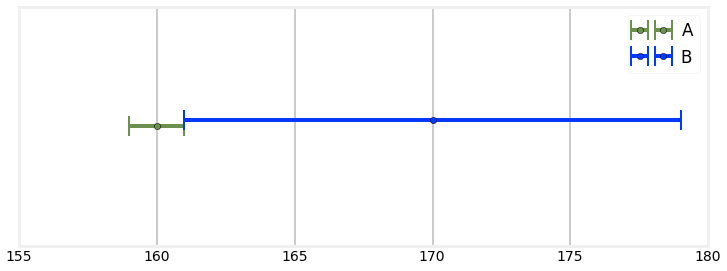

In [4]:
plt.errorbar([160], [1], xerr=1, fmt='o', label='A', capthick=2, capsize=10)
plt.errorbar([170], [1.05], xerr=9, fmt='o', label='B', capthick=2, capsize=10)
plt.ylim(0, 2)
plt.legend()
plt.gca().axes.yaxis.set_ticks([])
plt.show()

Here we can see that the only possible weight is 161 lbs. This is an important result. With two relatively inaccurate sensors we are able to deduce an extremely accurate result.

> So two sensors, even if one is less accurate than the other, is better than one.

However, we have strayed from our problem. No customer is going to want to buy multiple scales, and besides, we initially started with an assumption that all scales were equally (in)accurate. This insight will play a large role later, so don't forget it.

So, what if I have one scale, but I weigh myself many times? We concluded that if we had two scales of equal accuracy we should average the results of their measurements. What if I weigh myself 10,000 times with one scale? We have already stated that the scale is equally likely to return a number too large as it is to return one that is too small. It is not that hard to prove that the average of a large number of weights will be very close to the actual weight, but let's just write a simulation for now.

In [5]:
N = 10000
import random
weight_sum = 0
for i in range(N):
    # choose a random number between 160 and 170, assuming true
    # weight of 165
    measurement = random.uniform(160, 170) 
    weight_sum += measurement
    
average = weight_sum / N
print('Average of measurements is {:.4f}'.format(average))

Average of measurements is 165.0292


The exact number printed depends on your random number generator, but it should be very close to 165.

This code makes one assumption that probably isn't true - that the scale is just as likely to read 160 as 165 for a true weight of 165 lbs. This is almost never true. Real sensors are more likely to get readings nearer the true value, and are less and less likely to get readings the further away from the true value it gets. We will cover this in detail in the Gaussian chapter. For now, I will use without further explanation the `random.gauss()` function, which will produce more values nearer 165 lbs, and fewer further away. Take it on faith for now that this will produce noisy measurements very similar to how a real scale would.

In [6]:
N = 10000
weight_sum = 0
for i in range(N):
    # choose a random number centered around 165 lbs, with a 5 lb error.
    measurement = random.gauss(165, 5.) 
    weight_sum += measurement
    
average = weight_sum / N
print('Average of measurements is {:.4f}'.format(average))

Average of measurements is 164.9868


The answer again is very close to 165. 

Okay, great, we have an answer to our sensor problem! But it is not a very practical answer. No one has the patience to weigh themselves ten thousand, or even a dozen times. 

So, let's play 'what if' again. What if you measured your weight once a day, and got the readings 170, 161, and then 169. Did you gain weight, lose weight, or is this all just noisy measurements? 

We really can't say. The first measurement was 170, and the last was 169, implying a 1 lb loss. But if the scale is only accurate to 10 lbs, that is explainable by noise. I could have actually gained weight; maybe my weight on day one was 165 lbs, and on day three it was 172. It is possible to get those weight readings with that weight gain. My scale tells me I am losing weight, and I am actually gaining weight! Let's look at that in a chart. I've plotted the weighings along with the error bars, and then some possible weight gain/losses that could be explained by those measurements in dotted green lines.

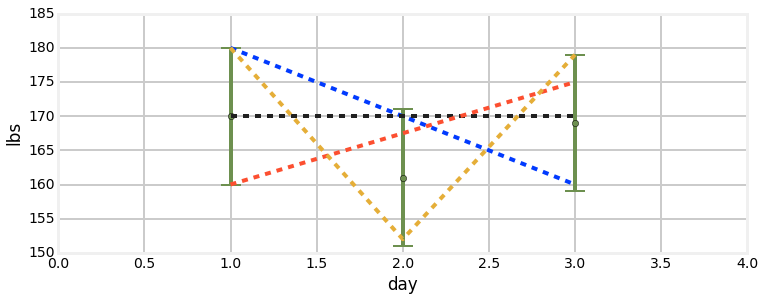

In [7]:
plt.errorbar([1, 2, 3], [170, 161, 169], 
             xerr=0, yerr=10, fmt='o', capthick=2, capsize=10)

plt.plot([1, 3], [180, 160], c='g', ls='--')
plt.plot([1, 3], [170, 170], c='g', ls='--')
plt.plot([1, 3], [160, 175], c='g', ls='--')
plt.plot([1, 2, 3], [180, 152, 179], c='g', ls='--')
plt.xlim(0,4); plt.ylim(150, 185)
plt.xlabel('day')
plt.ylabel('lbs')
plt.show()

As we can see there is an extreme range of weight changes that could be explained by these three measurements. Shall we give up? No. Recall that we are talking about measuring a humans' weight. There is no way for a human to weigh 180 lbs on day 1, and 160 lbs on day 3. or to lose 30 lbs in one day only to gain it back the next (we will assume no amputations or other trauma has happened to the person). The behavior of the physical system we are measuring should influence how we interpret the measurements. 
 
Suppose I take a different scale, and I get the following measurements: 169, 170, 169, 171, 170, 171, 169, 170, 169, 170. What does your intuition tell you? It is possible, for example, that you gained 1 lb each day, and the noisy measurements just happens to look like you stayed the same weight. Equally, you could have lost 1 lb a day and gotten the same readings. But is that likely? How likely is it to flip a coin and get 10 heads in a row? Not very likely. We can't prove it based solely on these readings, but it seems pretty likely that my weight held steady. In the chart below I've plotted the measurements with error bars, and a likely true weight in dashed green. This dashed line is not meant to be the 'correct' answer to this problem, just one that is reasonable and could be explained by the measurement.

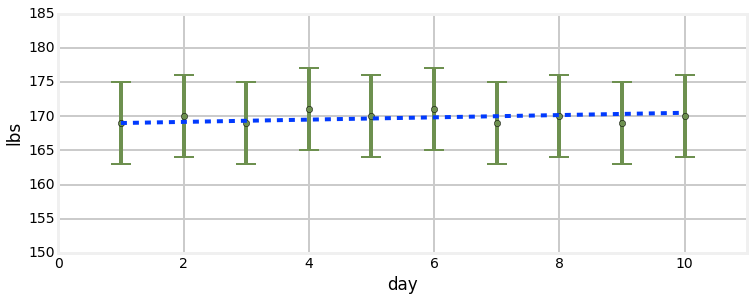

In [8]:
plt.errorbar(range(1, 11), [169, 170, 169,171, 170, 171, 169, 170, 169, 170], 
             xerr=0, yerr=6, fmt='o', capthick=2, capsize=10)
plt.plot([1, 10], [169, 170.5], c='g', ls='--')
plt.xlim(0, 11); plt.ylim(150, 185)
plt.xlabel('day')
plt.ylabel('lbs')
plt.show()

Another what if: what if the readings were 158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0? Let's look at a chart of that and then answer some questions.

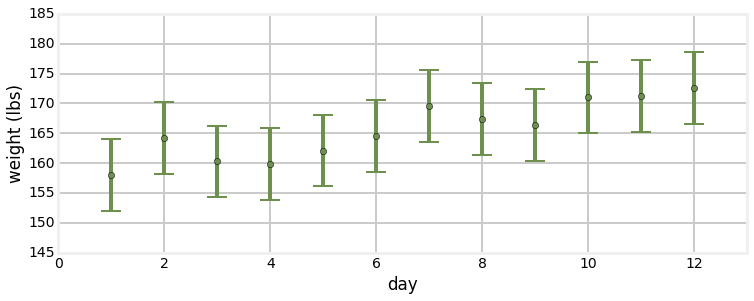

In [9]:
weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6,
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
plt.errorbar(range(1, 13), weights,
             xerr=0, yerr=6, fmt='o', capthick=2, capsize=10)

plt.xlim(0, 13); plt.ylim(145, 185)
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plt.show()

Does it 'seem' likely that I lost weight and this is just really noisy data? Not really. Does it seem likely that I held the same weight? Again, no. This data trends upwards over time; not evenly, but definitely upwards. We can't be sure, but that surely looks like a weight gain, and a significant weight gain at that. Let's test this assumption with some more plots. It is often easier to 'eyeball' data in a chart versus a table.

So let's look at two hypotheses. First, let's assume our weight did not change. To get that number we agreed that we should just average all the measurements. Let's look at that.

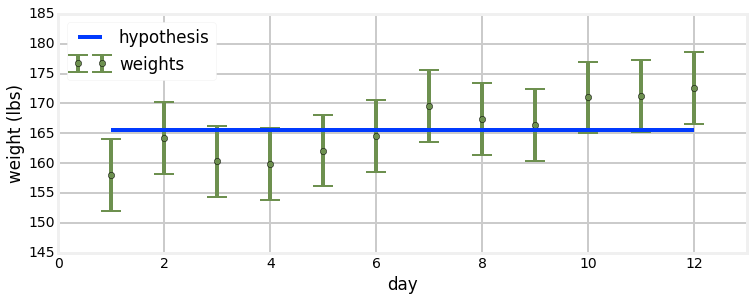

In [10]:
import numpy as np
ave = np.sum(weights) / len(weights)
plt.errorbar(range(1,13), weights, label='weights',
             yerr=6, fmt='o', capthick=2, capsize=10)
plt.plot([1, 12], [ave,ave], c='r', label='hypothesis')
plt.xlim(0, 13); plt.ylim(145, 185)
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plt.legend(loc='best')
plt.show()

That doesn't look very convincing. In fact, we can see that there is no horizontal line that we could draw that is inside all of the error bars.

Now, let's assume we we gained weight. How much? I don't know, but numpy does! We just want to draw a line through the measurements that looks 'about' right. numpy has functions that will do this according to a rule called "least squares fit". Let's not worry about the details of that computation, or why we are writing our own filter if numpy provides one, and just plot the results.

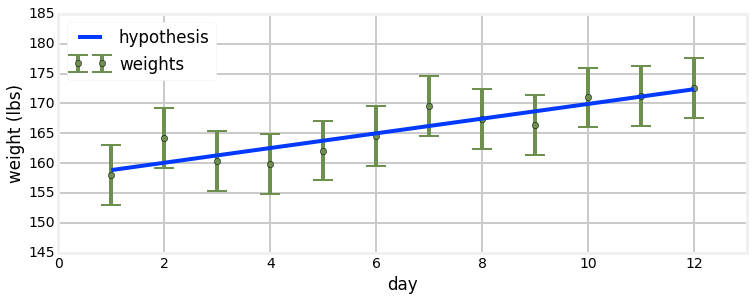

In [11]:
xs = range(1, len(weights)+1)
line = np.poly1d(np.polyfit(xs, weights, 1))
plt.errorbar(range(1, 13), weights, label='weights',
             yerr=5, fmt='o', capthick=2, capsize=10)
plt.plot (xs, line(xs), c='r', label='hypothesis')
plt.xlim(0, 13); plt.ylim(145, 185)
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plt.legend(loc='best')
plt.show()

This looks much better, at least to my eyes. Notice now the hypothesis lies very close to each measurement, whereas in the previous plot the hypothesis was often quite far from the measurement. It seems far more likely to be true that I gained weight than I didn't gain any weight. Did I actually gain 13 lbs? Who can say? That seems impossible to answer.

"But is it impossible?" pipes up a coworker.

Let's try something crazy. Let's just assume that I know I am gaining about one lb a day. It doesn't matter how I know that right now, just assume I know it is approximately correct. Maybe I am eating a 6000 calorie a day diet, which would result in such a weight gain. Or maybe there is another way to estimate the weight gain. Let's just see if we can make use of such information if it was available without worrying about the source of that information just yet.

The first measurement was 158. We have no way of knowing any different, so let's just accept that as our estimate. If our weight today is 158, what will it be tomorrow? Well, we think we are gaining weight at 1 lb/day, so our prediction is 159, like so:

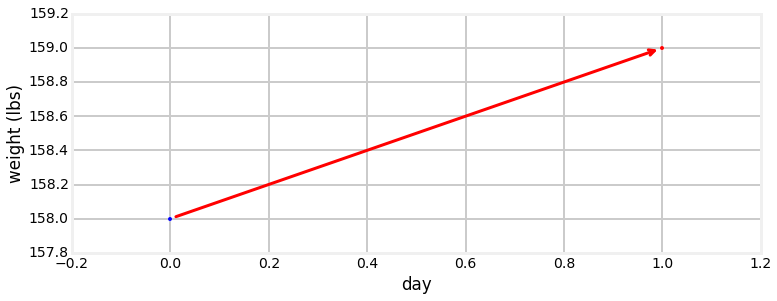

In [12]:
# a lot of the plotting code is not particularly useful to read, 
# so for each chapter I have placed the uninteresting code in a 
# file named xxx_internal. I import this  file and call whatever 
# function I need.

import gh_internal
gh_internal.plot_estimate_chart_1()

Okay, but what good is this? Sure, we could just assume the 1 lb/day is accurate, and just predict our weight for 10 days, but then why use a scale at all if we don't incorporate its readings? So let's look at the next measurement. We step on the scale again and it displays 164.2 lbs.

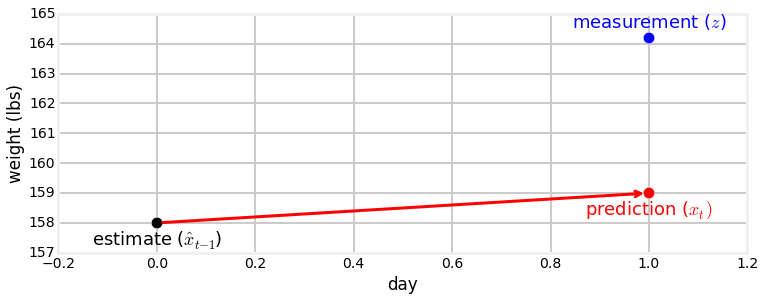

In [13]:
gh_internal.plot_estimate_chart_2()

Here the measurement is in blue, the previous estimate (output of the filter) is black, and the estimate is red. So we have a problem. Our prediction doesn't match our measurement. But, that is what we expected, right?. If the prediction was always exactly the same as the measurement, it would not be capable of adding any information to the filter. 

> The key insight to this entire book is in the next paragraph. Read it carefully!

So what do we do? If we only take data from the measurement then the prediction will not affect the result. If we only take data from the prediction then the measurement will be ignored. If this is to work we need to take some kind of *blend of the prediction and measurement* (I've italicized the key point).

Blending two values - this sounds a lot like the two scale problem earlier. Using the same reasoning as before we can see that the only thing that makes sense is to choose a number between the prediction and the measurement. For example, an estimate of 165 makes no sense, nor does 157. Our estimates should like between 159 (the prediction) and 164.2 (the measurement).

Should it be half way? Maybe, but in general it seems like we might know that our prediction is more or less accurate compared to the measurements. Probably the accuracy of our prediction differs from the accuracy of the scale. Recall what we did when A was much more accurate than B - we scaled the answer to be closer to A than B. Let's look at that in a chart.

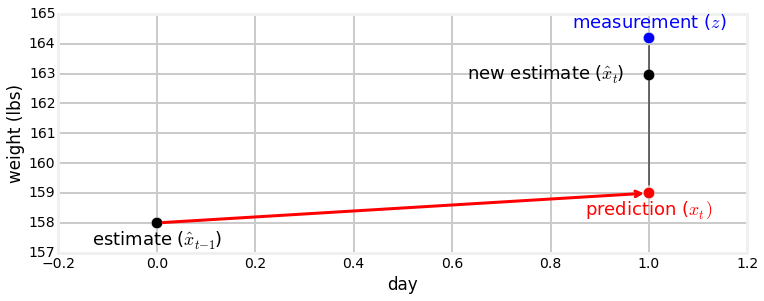

In [14]:
gh_internal.plot_estimate_chart_3()

Now let's try a randomly chosen number to scale our estimate: $\frac{4}{10}$. Our estimate will be four tenths the measurement and the rest will be from the prediction. In other words, we are expressing a belief here, a belief that the prediction is somewhat more likely to be correct than the measurement. We compute that as

$$ new estimate = prediction + \frac{4}{10}(measurement - prediction)
$$

The difference between the measurement and prediction is called the *residual*, which is depicted by the black vertical line in the plot above. This will become an important value to use later on, as it is an exact computation of the difference between measurements and the filter's output. Smaller residuals imply better performance.

Let's just code that up and see the result when we test it against the series of weights from above. We have to take into account one other factor. Weight gain has units of lbs/time, so to be general we will need to add a time step $t$, which we will set to 1 (day). 

I hand generated the weight data to correspond to a true starting weight of 160 lbs, and a weight gain of 1 lb per day. In other words one day one the true weight is 160lbs, on the second day the true weight is 161 lbs, and so on. 

We need to make a guess for the initial weight to feed into the filter. It is too early to talk about strategies for making that initial guess/estimate, so for now I will just assume 159 lbs.

previous: 160.00, prediction: 161.00 estimate 159.80
previous: 159.80, prediction: 160.80 estimate 162.16
previous: 162.16, prediction: 163.16 estimate 162.02
previous: 162.02, prediction: 163.02 estimate 161.77
previous: 161.77, prediction: 162.77 estimate 162.50
previous: 162.50, prediction: 163.50 estimate 163.94
previous: 163.94, prediction: 164.94 estimate 166.80
previous: 166.80, prediction: 167.80 estimate 167.64
previous: 167.64, prediction: 168.64 estimate 167.75
previous: 167.75, prediction: 168.75 estimate 169.65
previous: 169.65, prediction: 170.65 estimate 170.87
previous: 170.87, prediction: 171.87 estimate 172.16


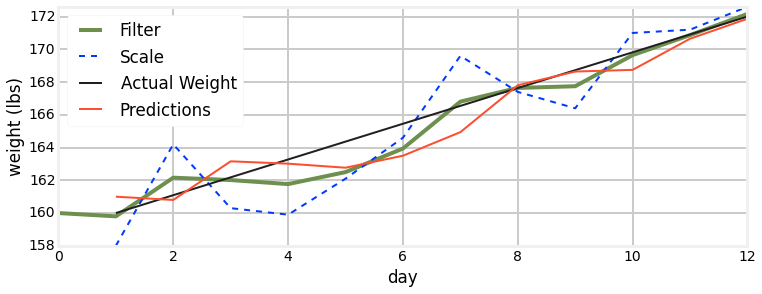

In [15]:
import book_plots as bp

weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

time_step = 1 # day
scale_factor = 4/10

def predict_using_gain_guess(weight, gain_rate): 
    # store the filtered results
    estimates = []
    predictions = []
    estimates.append(weight)

    # most filter literature uses 'z' for measurements
    for z in weights: 
        # predict new position
        prediction = weight + gain_rate * time_step

        # update filter 
        weight = prediction + scale_factor * (z - prediction)

        # save for plotting
        estimates.append(weight)
        predictions.append(prediction)
        print('previous: {:.2f}, prediction: {:.2f} estimate {:.2f}'.format(
              estimates[-2], prediction, weight))

    # plot results
    n = len(weights)
 
    bp.plot_filter(range(n+1), estimates)
    bp.plot_measurements(range(1, n+1), weights, c='b', label='Scale')
    bp.plot_track([1, n],[160, 160+n], c='k', label='Actual Weight')
    bp.plot_track(range(1, n+1), predictions, c='r', label='Predictions')
    plt.legend(loc=2)
    plt.xlabel('day')
    plt.ylabel('weight (lbs)')
    plt.xlim([0, n])
    plt.show()

initial_guess = 160.
predict_using_gain_guess (weight=initial_guess, gain_rate=1)

That is pretty good! There is a lot of data here, so let's talk about how to interpret it.  The thick green line shows the estimate from the filter. It starts at day 0 with the inital guess of 160 lbs. The red line shows the prediction that is made from the previous day's weight. So, on day one the previous weight was 160 lbs, the weight gain is 1 lb, and so the first prediction is 161 lbs. The estimate on day one is then part way between the prediction and measurement at 159.8 lbs. Above the chart is a print out of the previous weight, predicted weight, and new estimate for each day. Finally, the thin black line shows the actual weight gain of the person being weighed. 

The estimates are not a straight line, but they are straighter than the measurements and somewhat close to the trend line we created. Also, it seems to get better over time. 

This may strike you as quite silly; of course the data will look good if we assume the conclusion, that our weight gain is around 1 lb/day! Let's see what the filter does if our initial guess is bad. Let's see what happens if I predict that there is no weight gain.

previous: 160.00, prediction: 160.00 estimate 159.20
previous: 159.20, prediction: 159.20 estimate 161.20
previous: 161.20, prediction: 161.20 estimate 160.84
previous: 160.84, prediction: 160.84 estimate 160.46
previous: 160.46, prediction: 160.46 estimate 161.12
previous: 161.12, prediction: 161.12 estimate 162.51
previous: 162.51, prediction: 162.51 estimate 165.35
previous: 165.35, prediction: 165.35 estimate 166.17
previous: 166.17, prediction: 166.17 estimate 166.26
previous: 166.26, prediction: 166.26 estimate 168.16
previous: 168.16, prediction: 168.16 estimate 169.37
previous: 169.37, prediction: 169.37 estimate 170.66


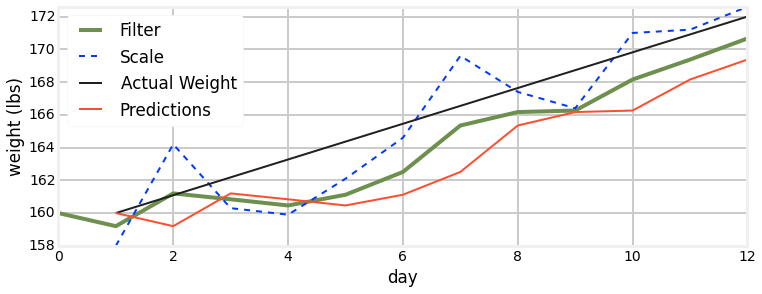

In [16]:
predict_using_gain_guess (weight=initial_guess, gain_rate=0)

That is not so impressive. Clearly a filter that requires us to correctly guess a rate of change is not very useful. Even if our initial guess was correct, the filter will fail as soon as that rate of change changes. If I stop overeating the filter will have extremely difficulty in adjusting to that change. 

But, 'what if'? What if instead of just leaving the weight gain at the initial guess of 1 lb (or whatever), we compute it from the existing measurements and estimates. On day one our estimate for the weight is:

$$
(160 + 1) + \frac{4}{10}(158-161) = 159.8
$$

On the next day we measure 164.2, which implies a weight gain of 4.4 lbs (since 164.2 - 159.8 = 4.4), not 1. Can we use this information somehow? It seems plausible. After all, the weight measurement itself is based on a real world measurement of our weight, so there is useful information. Our estimate of our weight gain may not be perfect, but it is surely better than just guessing our gain is 1 lb. Data is better than a guess, even if it is noisy.

So, should we just set the new gain/day to 4.4 lbs?  Hmm, sounds like our same problem again. Yesterday we though the weight gain was 1 lb, today we think it is 4.4 lbs. We have two numbers, and want to combine them somehow. Let's use our same tool, and the only tool we have so far - pick a value part way between the two. This time I will use another arbitrarily chosen number, $\frac{1}{3}$. The equation is identical as for the weight estimate except we have to incorporate time because this is a rate (gain/day):

$$new gain = old gain + \frac{1}{3}\frac{measurement - predicted~weight}{1~ day}
$$

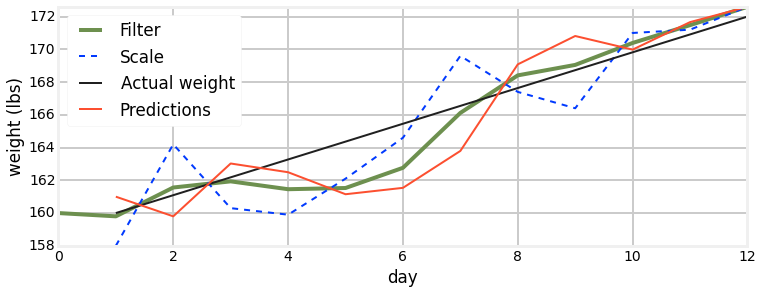

In [17]:
weight = 160  # initial guess
gain_rate = 1.0 # initial guess

time_step = 1
weight_scale = 4/10
gain_scale = 1/3
estimates = [weight]
predictions = []

for z in weights:
    # prediction step
    weight = weight + gain_rate*time_step
    gain_rate = gain_rate
    predictions.append(weight)
    
    # update step    
    residual = z - weight
    
    gain_rate = gain_rate + gain_scale   * (residual/time_step)
    weight    = weight    + weight_scale * residual
  
    estimates.append(weight)

# plot results
n = len(weights)
plt.xlim([1, n])
   
days = np.linspace(1, n, n)
bp.plot_filter(estimates)
bp.plot_measurements(days, weights, c='b', label='Scale')
bp.plot_track([1, n], [160, 160+n], c='k', label='Actual weight')
bp.plot_track(range(1, n+1), predictions, c='r', label='Predictions')
plt.legend(loc=2)
plt.xlabel('day')
plt.ylabel('weight (lbs)')
plt.show()

I think this is starting to look really good. We used no methodology for choosing our scaling factors of $\frac{4}{10}$ and $\frac{1}{3}$ (actually, they are poor choices for this problem), and we 'luckily' choose 1 lb/day as our initial guess for the weight gain, but otherwise all of the reasoning followed from very reasonable assumptions.

One final point before we go on. In the prediction step I wrote the line

    gain_rate = gain_rate
    
This obviously has no effect, and can be removed. I wrote this to emphasize that in the prediction step you need to predict next value for **all** variables, both *weight* and *gain_rate*. In this case we are assuming that the the gain does not vary, but when we generalize this algorithm we will remove that assumption. 

## The g-h Filter

This algorithm is known as the g-h filter. *g* and *h* refer to the two scaling factors that we used in our example. *g* is the scaling we used for the measurement (weight in our example), and *h* is the scaling for the change in measurement over time (lbs/day in our example).

This filter is the basis for a huge number of filters, including the Kalman filter. In other words, the Kalman filter is a form of the g-h filter, which I will prove later in the book. So is the Least Squares filter, which you may have heard of, and so is the Benedict-Bordner filter, which you probably have not. Each filter has a different way of assigning values to *g* and *h*, but otherwise the algorithms are identical. For example, the $\alpha$-$\beta$ filter just assigns a constant to *g* and *h*, constrained to a certain range of values. Other filters such as the Kalman will vary *g* and *h* dynamically at each time step.

**Let me repeat the key points as they are so important**. If you do not understand these you will not understand the rest of the book. If you do understand them, then the rest of the book will unfold naturally for you as mathematically elaborations to various 'what if' questions we will ask about *g* and *h*.

* Multiple data points are more accurate than one data point, so throw nothing away no matter how inaccurate it is
* Always choose a number part way between two data points to create a more accurate estimate
* Predict the next measurement and rate of change based on the current estimate and how much we think it will change
* The new estimate is then chosen as part way between the prediction and next measurement

Let's look at a visual depiction of the algorithm.

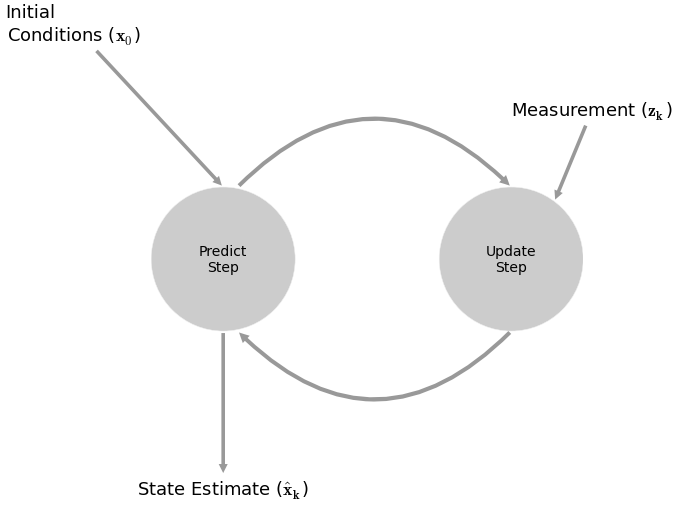

In [18]:
gh_internal.create_predict_update_chart()

Now let's explore a few different problem domains to better understand this. Consider the problem of trying to track a train on a track. The track constrains the position of the train to a very specific region. Furthermore, trains are large and slow. It takes them many minutes to slow down or speed up significantly. So, if I know that the train is at kilometer marker 23km at time t and moving at 60 kph, I can be extremely confident in predicting its position at time t + 1 second. And why is that important? Suppose we can only measure its position with an accuracy of 500 meters. So at t+1 sec the measurement could be anywhere from 22.5 km to 23 km. But the train is moving at 60 kph, which is 16.6 meters/second. So if the next measurement says the position is at 23.4 we know that must be wrong. Even if at time t the engineer slammed on the brakes the train will still be very close to 23.0166 km because a train cannot slow down very much at all in 1 second. If we were to design a filter for this problem (and we will a bit further in the chapter!) we would want to design a filter that gave a very high weighting to the prediction vs the measurement. 

Now consider the problem of tracking a thrown ball. We know that a ballistic object moves in a parabola in a vacuum when in a gravitational field. But a ball thrown on the surface of the Earth is influenced by air drag, so it does not travel in a perfect parabola. Baseball pitchers take advantage of this fact when they throw curve balls. Let's say that we are tracking the ball inside a stadium using computer vision. The accuracy of the computer vision tracking might be modest, but predicting the ball's future positions by assuming that it is moving on a parabola is not extremely accurate either. In this case we'd probably design a filter that gave roughly equal weight to the measurement and the prediction.

Now consider trying to track a child's balloon in a hurricane. We have no legitimate model that would allow us to predict the balloon's behavior except over very brief time scales (we know the balloon cannot go 10 miles in 1 second, for example). In this case we would design a filter that emphasized the measurements over the predictions.

Most of this book is devoted to expressing the concerns in the last three paragraphs mathematically, which then allows us to find an optimal solution (in a least squares sense). In this chapter we will merely be assigning different values to *g* and *h* in a more intuitive, and thus less optimal way. But the fundamental idea is just to blend somewhat inaccurate measurements with somewhat inaccurate models of how the systems behaves to get a filtered estimate that is better than either information source by itself.

## Notation and Nomenclature

I'll begin to introduce the nomenclature and variable names used in the literature. Some of this was already used in the above charts. Measurement is typically denoted $z$ and that is what we will use in this book (some literature uses $y$). Subscript $k$ indicates the time step, so $z_k$ is the data for this time step. A bold font denotes a vector or matrix. So far we have only considered having one sensor, and hence one sensor measurement, but in general we may have *n* sensors and *n* measurements. $\mathbf{x}$ denotes our data, and is bold to denote that it is a vector. For example, for our scale example, it represents both the initial weight and initial weight gain rate, like so:

$$\mathbf{x} = \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

So if the weight is 62 kg and the weight gain is 0.3 kg/day, the vector would be

$$\mathbf{x} = \begin{bmatrix}62 \\ 0.3\end{bmatrix}$$

Finally, a hat '$\hat{}$' indicates an *estimate*. So the output of the predict step time $k$ at is the *estimate* of our state, which we denote as $\mathbf{\hat{x}_k}$. 

So, the algorithm is simple. The state is initialized with $\mathbf{x_0}$. We then enter a loop, predicting the state for time $k$ from the values from time $k-1$. We then get the measurement $z_k$ and choose some intermediate point between the measurements and prediction, creating the estimate $\mathbf{\hat{x}_k}$.

## Exercise: Write Generic Algorithm

In the example above, I explicitly coded this to solve the weighing problem that we've been discussing throughout the chapter. For example, the variables are named "weight_scale", "gain", and so on. I did this to make the algorithm easy to follow - you can easily see that we correctly implemented each step. But, that is code written for exactly one problem, and the algorithm is the same for any problem. So let's rewrite the code to be generic - to work with any problem. Use this function signature:

    def g_h_filter(data, x0, dx, g, h):
        """
        Performs g-h filter on 1 state variable with a fixed g and h.

        'data' contains the data to be filtered.
        'x0' is the initial value for our state variable
        'dx' is the initial change rate for our state variable
        'g' is the g-h's g scale factor
        'h' is the g-h's h scale factor
        'dt' is the length of the time step 
        """

Test it by passing in the same weight data as before, plot the results, and visually determine that it works.

### Solution and Discussion

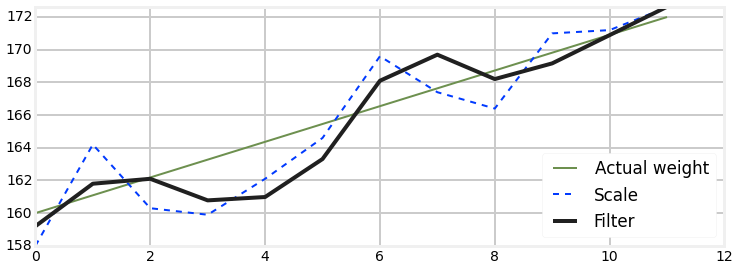

12


In [19]:
def g_h_filter(data, x0, dx, g, h, dt=1., pred=None):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.
    
    'data' contains the data to be filtered.
    'x0' is the initial value for our state variable
    'dx' is the initial change rate for our state variable
    'g' is the g-h's g scale factor
    'h' is the g-h's h scale factor
    'dt' is the length of the time step 
    'pred' is an optional list. If provided, each prediction will
    be stored in it
    """
    
    x = x0
    results = []
    for z in data:
        #prediction step
        x_est = x + (dx*dt)
        dx = dx
        
        if pred is not None:
            pred.append(x_est)
        
        # update step
        residual = z - x_est
        dx = dx    + h * (residual) / dt
        x  = x_est + g * residual
        
        results.append(x)
        
    return np.asarray(results)

def plot_g_h_results(measurements, filtered_data, 
                     title='', z_label='Scale', ):    
    bp.plot_measurements(measurements, label=z_label)
    bp.plot_filter(filtered_data)
    plt.legend(loc=4)
    plt.title(title)
    plt.gca().set_xlim(left=0,right=len(measurements))
    plt.show()


plt.xlim([0, 10])
bp.plot_track([0, 11],[160, 172], label='Actual weight')
data = g_h_filter(data=weights, x0=160, dx=1, g=6./10, h=2./3, dt=1.)
plot_g_h_results(weights, data)
print(len(weights))

## Choice of g and h

The g-h filter is not one filter - it is a classification for a family of filters. Eli Brookner in *Tracking and Kalman Filtering Made Easy* lists 11, and I am sure there are more. Not only that, but each type of filter has numerous subtypes. Each filter is differentiated by how *g* and *h* are chosen. So there is no 'one size fits all' advice that I can give here. Some filters set *g* and *h* as constants, others vary them dynamically. The Kalman filter varies them dynamically at each step. Some filters allow *g* and *h* to take any value within a range, others constrain one to be dependent on the other by some function $f(\dot{}), \mbox{where }g = f(h)$.

The topic of this book is not the entire family of g-h filters; more importantly, we are interested in the *Bayesian* aspect of these filters, which I have not addressed yet. Therefore I will not cover selection of *g* and *h* in depth. Eli Brookner's book *Tracking and Kalman Filtering Made Easy* is an excellent resource for that topic, if it interests you. If this strikes you as an odd position for me to take, recognize that the typical formulation of the Kalman filter does not use *g* and *h* at all; the Kalman filter is a g-h filter because it mathematically reduces to this algorithm. When we design the Kalman filter we will be making a number of carefully considered choices to optimize it's performance, and those choices indirectly affect *g* and *h*, but you will not be choosing *g* and *h* directly. Don't worry if this is not too clear right now, it will be much clearer later after we develop the Kalman filter theory.

However, it is worth seeing how varying *g* and *h* affects the results, so we will work through some examples. This will give us strong insight into the fundamental strengths and limitations of this type of filter, and help us understand the behavior of the rather more sophisticated Kalman filter.

## Exercise: create measurement function

Now let's write a function that generates noisy data for us. Recall from chapter 0 (**author's note**: I have not yet written chapter 0!) that we model a noisy signal as the signal plus white noise generated by `numpy.random.randn()`.  We want a function that we call with the starting value, the amount of change per step, the number of steps, and the amount of noise we want to add. It should return a list of the data. Test it by creating 30 points, filtering it with `g_h_filter()`, and plot the results with `plot_g_h_results()`.

In [20]:
# your code here

### Solution

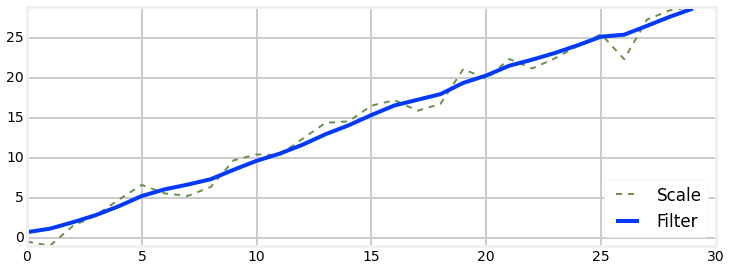

In [21]:
import numpy.random as random
def gen_data(x0, dx, count, noise_factor):
    return [x0 + dx*i + random.randn()*noise_factor for i in range (count)]

measurements = gen_data(0, 1, 30, 1)
data = g_h_filter(data=measurements, x0=0, dx=1, dt=1, g=.2, h=0.02)
plot_g_h_results(measurements, data)

## Exercise: Bad Initial Conditions

Now write code that uses `gen_data` and `g_h_filter` to filter 100 data points that starts at 5, has a derivative of 2, a noise scaling factor of 10, and uses g=0.2 and h=0.02. Set you initial guess for x to be 100.

In [22]:
# your code here

### Solution and Discussion

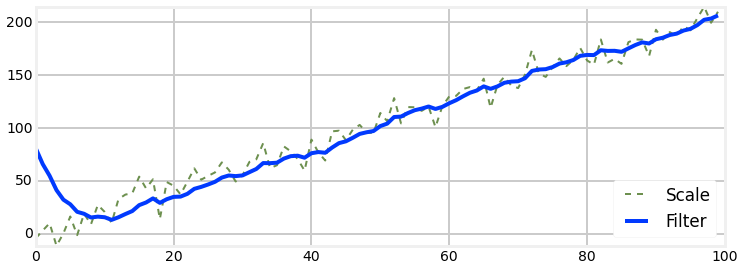

In [23]:
zs = gen_data(x0=5, dx=2, count=100, noise_factor=10)
data = g_h_filter(data=zs, x0=100., dx=2., dt=1., g=0.2, h=0.01)
plot_g_h_results(measurements=zs, filtered_data=data)

The filter starts out with estimates that are far from the measured data due to the bad initial guess of 100. You can see that it 'rings' before settling in on the measured data. 'Ringing' means that the signal overshoots and undershoots the data in a sinusoidal type pattern. This is a very common phenomena in filters, and a lot of work in filter design is devoted to minimizing ringing. That is a topic that we are not yet prepared to address, but I wanted to show you the phenomenon.

## Exercise: Extreme Noise

Rerun the same test, but this time use a noise factor of 100. Remove the initial condition ringing by changing the initial condition from 100 down to 5.

In [24]:
# your code here

### Solution and Discussion

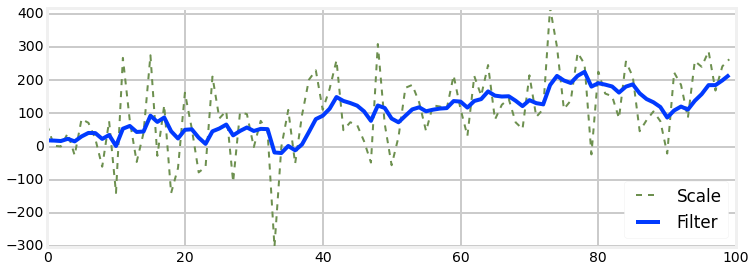

In [25]:
zs = gen_data (x0=5, dx=2, count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=2., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

This doesn't look so wonderful to me. We can see that perhaps the filtered signal varies less than the noisy signal, but it is far from the straight line. If we were to plot just the filtered result no one would guess that the signal with no noise starts at 5 and increments by 2 at each time step. And while in locations the filter does seem to reduce the noise, in other places it seems to overshoot and undershoot.

At this point we don't know enough to really judge this. We added **a lot** of noise; maybe this is as good as filtering can get. However, the existence of the multitude of chapters beyond this one should suggest that we can do much better than this suggests.

## Exercise: The Effect of Acceleration

Write a new data generation function that adds in a constant acceleration factor to each data point. In other words, increment dx as you compute each data point so that the velocity (dx) is ever increasing. Set the noise to 0, $g=0.2$ and $h=0.02$ and plot the results. Explain what you see.

In [26]:
# your code here

### Solution and Discussion

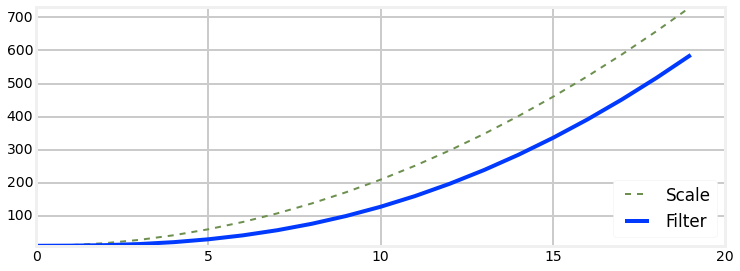

In [27]:
def gen_data(x0, dx, count, noise_factor, accel=0):
    zs = []
    for i in range(count):
        zs.append(x0 + dx*i + random.randn()*noise_factor)
        dx += accel
    return zs
   
predictions = []
zs = gen_data(x0=10, dx=0, count=20, noise_factor=0, accel=2)
data = g_h_filter(data=zs, x0=10, dx=0, g=0.2, h=0.02, pred=predictions)
plt.xlim([0, 20])
plot_g_h_results(measurements=zs, filtered_data=data)

Each prediction lags behind the signal. If you think about what is happening this makes sense. Our model assumes that velocity is constant. The g-h filter computes the first derivative of $x$ (we use $\dot{x}$ to denote the derivative) but not the second derivative $\ddot{x}$. So we are assuming that $\ddot{x}=0$. At each prediction step we predict the new value of x as $x + \dot{x}*t$. But because of the acceleration the prediction must necessarily fall behind the actual value. We then try to compute a new value for $\dot{x}$, but because of the $h$ factor we only partially adjust $\dot{x}$ to the new velocity. On the next iteration we will again fall short.

Note that there is no adjustment to $g$ or $h$ that we can make to correct this problem. This is called the *lag error* or *systemic error* of the system. It is a fundamental property of g-h filters. Perhaps your mind is already suggesting solutions or workarounds to this problem. As you might expect, a lot of research has been devoted to this problem, and we will be presenting various solutions to this problem in this book.
> The 'take home' point is that the filter is only as good as the mathematical model used to express the system. 

## Exercise: Varying g

Now let's look at the effect of varying g. Before you perform this exercise, recall that g is the scale factor for choosing between the measurement and prediction. What do you think of a large value of g will be? A small value? 

Now, let the `noise_factor=50` and `dx=5`. Plot the results of $g = 0.1\mbox{, } 0.5,\mbox{ and } 0.9$.

In [28]:
# your code here

### Solution and Discussion

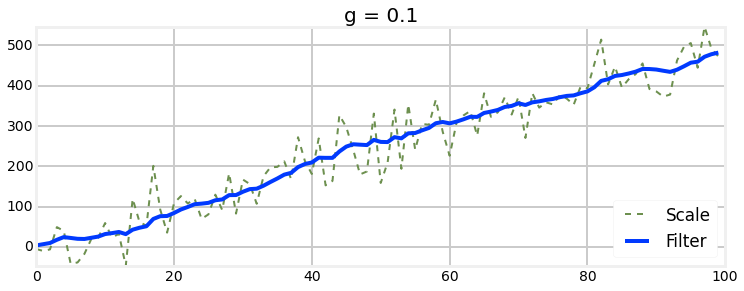

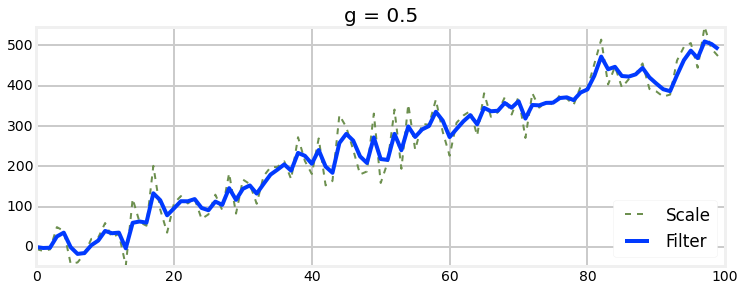

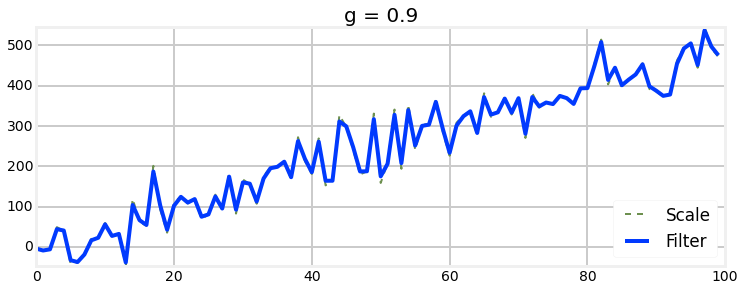

In [29]:
zs = gen_data(x0=5, dx=5, count=100, noise_factor=50)

data = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.1, h=0.01)
plot_g_h_results (zs, data, 'g = 0.1')

data = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.5, h=0.01)
plot_g_h_results (zs, data, 'g = 0.5')

data = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.9, h=0.01)
plot_g_h_results(zs, data, 'g = 0.9')

It is clear that as $g$ is larger we more closely follow the measurement instead of the prediction. When $g=0.9$ we follow the signal almost exactly, and reject almost none of the noise. One might naively conclude that $g$ should always be very small to maximize noise rejection. However, that means that we are mostly ignoring the measurements in favor of our prediction. What happens when the signal changes not due to noise, but an actual state change? Let's look. I will create data that has $\dot{x}=1$ for 9 steps before changing to $\dot{x}=0$. 

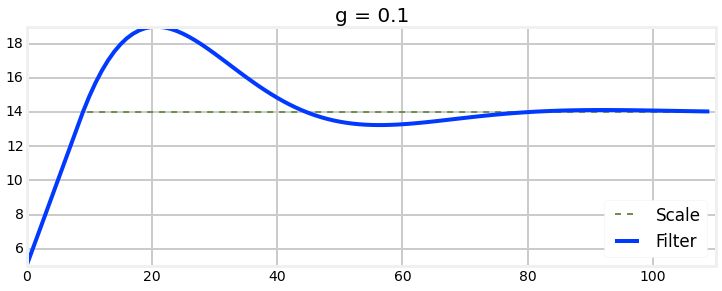

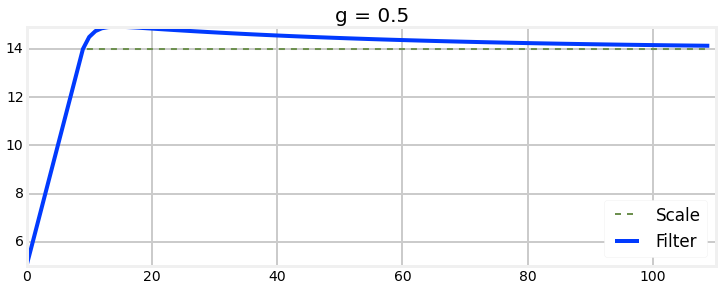

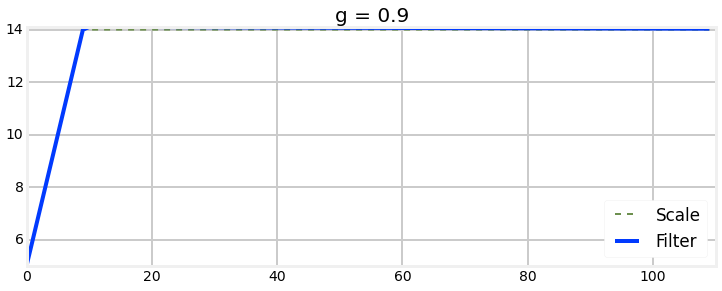

In [30]:
zs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

for i in range(100):
    zs.append(14)

data = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.1, h=0.01)
plot_g_h_results(zs, data, 'g = 0.1')

data = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.5, h=0.01)
plot_g_h_results(zs, data, 'g = 0.5')

data = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.9, h=0.01)
plot_g_h_results(zs, data, 'g = 0.9')

Here we can see the effects of ignoring the signal. We not only filter out noise, but legitimate changes in the signal as well. 

Maybe we need a 'Goldilocks' filter, where is not too large, not too small, but just right? Well, not exactly. As alluded to earlier, different filters choose g and h in different ways depending on the mathematical properties of the problem. For example, the Benedict-Bordner filter was invented to minimize the transient error in this example, where $\dot{x}$ makes a step jump. We will not discuss this filter in this book, but here are two plots chosen with different allowable pairs of g and h. This filter design minimizes transient errors for step jumps in $\dot{x}$ at the cost of not being optimal for other types of changes in $\dot{x}$.

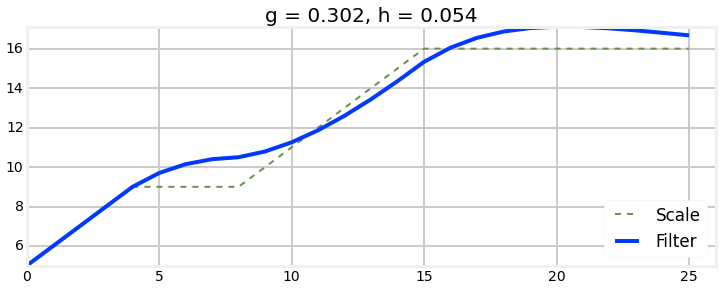

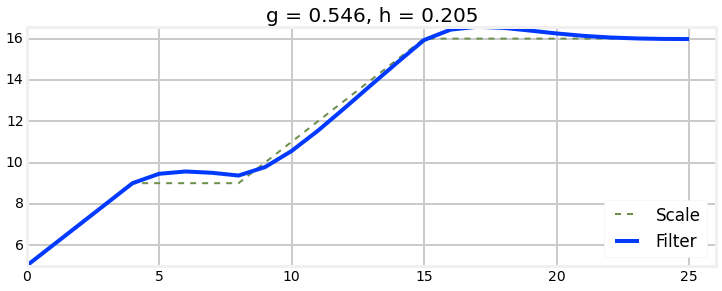

In [31]:
zs = [5,6,7,8,9,9,9,9,9,10,11,12,13,14,15,16,16,16,16,16,16,16,16,16,16,16]
    
data = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.302, h=0.054)
plot_g_h_results(zs, data, 'g = 0.302, h = 0.054')

data = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.546, h=0.205)
plot_g_h_results(zs, data, 'g = 0.546, h = 0.205')

## Varying h

Now let's leave g unchanged and investigate the effect of modifying h. We know that h affects how much of we favor the measurement of $\dot{x}$ vs our prediction. But what does this *mean*? If our signal is changing a lot (quickly relative to the time step of our filter), then a large $h$ will cause us to react to those transient changes rapidly. A smaller $h$ will cause us to react more slowly.

We will look at three examples. We have a noiseless measurement that slowly goes from 0 to 1 in 50 steps. Our first filter uses a nearly correct initial value for $\dot{x}$ and a small $h$. You can see from the output that the filter output is very close to the signal. The second filter uses the very incorrect guess of $\dot{x}=2$. Here we see the filter 'ringing' until it settles down and finds the signal. The third filter uses the same conditions but it now sets $h=0.5$. If you look at the amplitude of the ringing you can see that it is much smaller than in the second chart, but the frequency is greater. It also settles down a bit quicker than the second filter, though not by much.

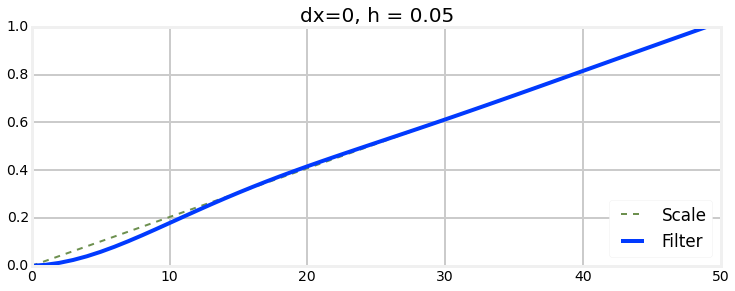

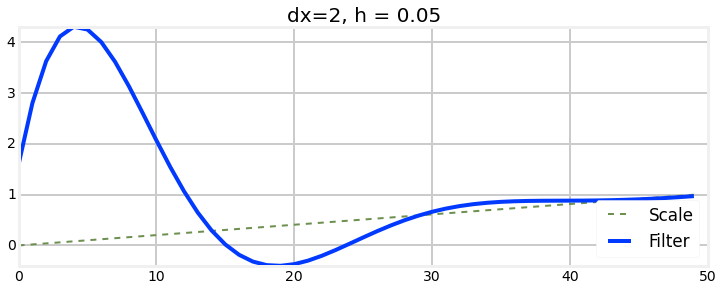

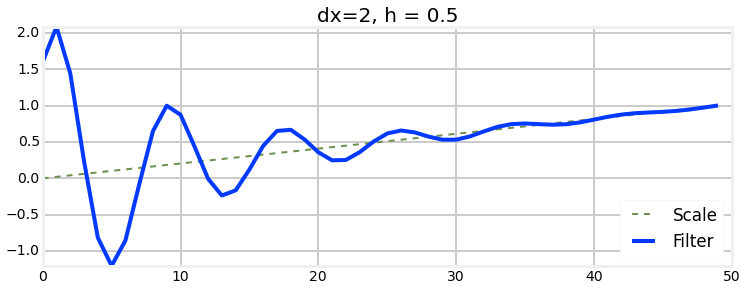

In [32]:
zs = np.linspace(0, 1, 50)

data = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05)
plot_g_h_results(zs, data, 'dx=0, h = 0.05')

data = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05)
plt.ylim([-1, 5])
plot_g_h_results(zs, data, 'dx=2, h = 0.05')

data = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)
plt.ylim([-1, 5])
plot_g_h_results(zs, data, 'dx=2, h = 0.5')

## Interactive Example

For those of you running this in IPython Notebook I've written an interactive version of the filter so you can see the effect of changing $\dot{x}$, $g$ and $h$ in real time. As you adjust the sliders for $\dot{x}$, $g$ and $h$ the date will be refiltered and the results plotted for you.

If you really want to test yourself, read the next paragraph and try to predict the results before you move the sliders. 

Some things to try include setting $g$  and $h$ to their miminum values. See how perfectly the filter tracks the data! But now adjust $\dot{x}$ to larger or smaller than 5. The filter should diverge from the data and never reacquire it. Start adding back either $g$ or $h$ and see how the filter snaps back to the data. See what the difference in the line is when you add only $g$ vs only $h$. Can you explain the reason for the difference? Then try setting $g$ greater than 1. Can you explain the results? Put $g$ back to a reasonable value (such as 0.1), and then make $h$ very large. Can you explain these results? Finally, set both $g$ and $h$ to their largest values. 

If you want to explore with this more, change the value of the array `zs` to the values used in any of the charts above and rerun the cell to see the result.

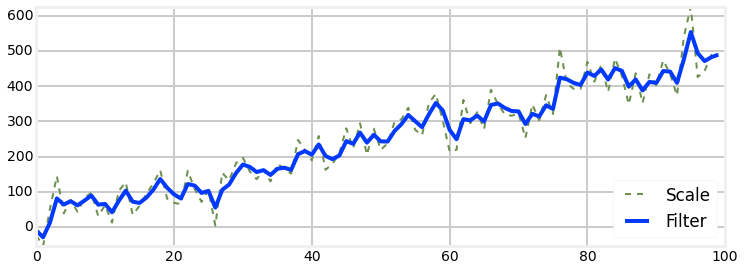

<function __main__.interactive_gh>

In [33]:
from IPython.html.widgets import interact, interactive, fixed
import IPython.html.widgets as widgets

zs = gen_data(x0=5, dx=5, count=100, noise_factor=50)

def interactive_gh(dx, g, h):
    data = g_h_filter(data=zs, x0=0., dx=dx, dt=1.,g=g, h=h)
    plot_g_h_results(zs, data)

interact (interactive_gh, 
          dx=widgets.FloatSliderWidget(value=5., min=1., max=10.), 
          g=widgets.FloatSliderWidget(value=0.5, min=0.01, max=2), 
          h=widgets.FloatSliderWidget(value=0.02, min=0.0, max=0.5, step=0.01))

## Tracking a Train

Now let's try a practical example. Earlier in the chapter we talked about tracking a train. Trains are heavy and slow, thus they cannot change speed quickly. They are on a track, so they cannot change direction except by slowing to a stop and then reversing course. Hence, we can conclude that if we already know the train's approximate position and velocity then we can predict its position in the near future with a great deal of accuracy. A train just cannot change its velocity much in a second or two. 

So let's write a filter for a train. Its position is expressed as its position on the track in relation to some fixed point which we say is 0 km. I.e., a position of 1 means that the train is 1 km away from the fixed point. Velocity is expressed as meters per second. We perform measurement of position once per second, and the error is $\pm$ 500 meters. How should we implement our filter?

First, let's just simulate the situation without a filter. We will assume that the train is currently at kilometer 23, and moving at 15 m/s. We can code this as 

    pos = 23*1000
    vel = 15
    
Now we can compute the position of the train at some future time, *assuming* no change in velocity, with

    def compute_new_position(pos, vel, dt=1):
        return pos + (vel * dt)
        
We can simulate the measurement by adding in some random noise to the position. Here our error is 500m, so the code might look like:

    def measure_position(pos):
        return pos + random.randn()*500
        
Let's put that in a cell and plot the results of 100 seconds of simulation.

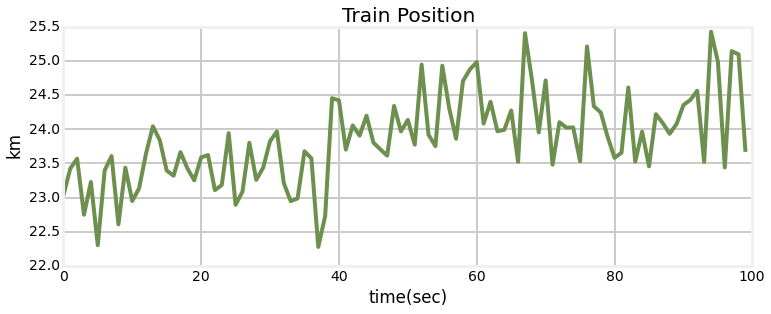

In [34]:
from numpy.random import randn

def compute_new_position(pos, vel, dt=1):
    """ dt is the time delta in seconds."""
    return pos + (vel * dt)


def measure_position(pos):
    return pos + randn()*500


def gen_train_data(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        zs.append(measure_position(pos))
    return np.asarray(zs)

    
pos = 23*1000
vel = 15
zs = gen_train_data(pos, vel, 100)

plt.plot(zs/1000) # convert to km
plt.xlabel('time(sec)'); plt.ylabel('km')
plt.title('Train Position')
plt.show()

We can see from the chart how poor the measurements are. No real train could ever move like that. 

So what should we set *g* and *h* to if we want to filter this data? We have not developed the theory for this, but let's try to get a reasonable answer by the seat of our pants. We know that the measurements are very inaccurate, so we don't want to give them much weight at all. To do this we need to choose a very small *g*. We also know that trains can not accelerate or decelerate quickly, so we also want a very small *h*. For example:

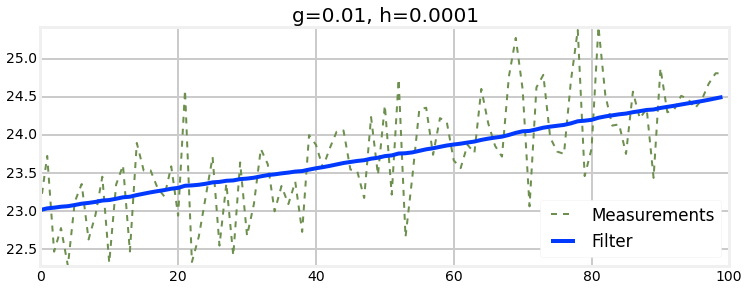

In [35]:
zs = gen_train_data(23000, 15, 100)
data = g_h_filter(data=zs, x0=23000, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000, data/1000, 'g=0.01, h=0.0001', z_label='Measurements')

That is pretty good for an initial guess. Lets make *g* larger to see the effect.

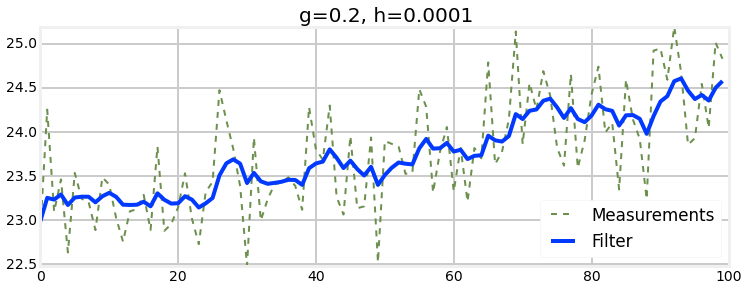

In [36]:
zs = gen_train_data(23000, 15, 100)
data = g_h_filter(data=zs, x0=23000, dx=15., dt=1., g=.2, h=0.0001)
plot_g_h_results(zs/1000, data/1000, 'g=0.2, h=0.0001', z_label='Measurements')

We made `g=0.2` and we can see that while the train's position is smoothed, the estimated position (and hence velocity) fluctuates a lot in a very tiny frame, far more than a real train can do. So empirically we know that we want `g<<0.2`.

Now let's see the effect of a poor choice for *h*.

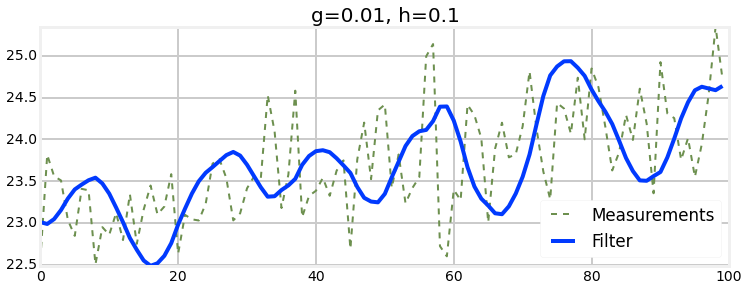

In [37]:
zs = gen_train_data(23000, 15, 100)
data = g_h_filter(data=zs, x0=23000, dx=15., dt=1., g=0.01, h=0.1)
plot_g_h_results(zs/1000, data/1000, 'g=0.01, h=0.1', z_label='Measurements')

Here the position changes smoothly thanks to the small *g*, but the large *h* makes the filter very reactive to the measurements. This happens because in the course of a few seconds the rapidly changing measurement implies a very large velocity change, and a large *h* tells the filter to react to those changes quickly. Trains cannot change velocity quickly, so the filter is not doing a good job of filtering the data - the filter is changing velocity faster than a train can.

Finally, let's add some acceleration to the train. I don't know how fast a train can actually accelerate, but let's say it is accelerating at 0.2 m/sec^2. 

In [38]:
def gen_train_data_with_acc(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        vel += 0.2
        zs.append(measure_position(pos))
    return np.asarray(zs) 

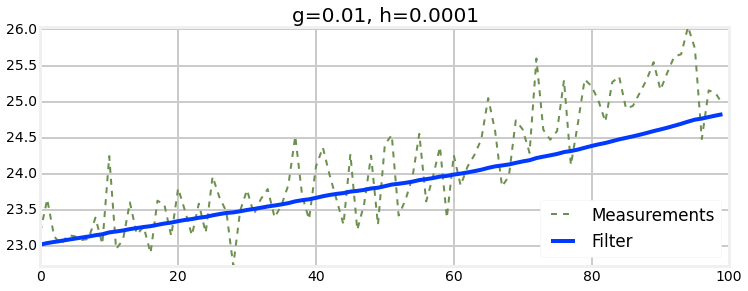

In [39]:
zs = gen_train_data_with_acc(23000, 15, 100)
data = g_h_filter(data=zs, x0=23000, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000, data/1000, 'g=0.01, h=0.0001', z_label='Measurements')

Here we see that the filter is not quite tracking the train anymore due to the acceleration. We can fiddle with *h* to let it track better, at the expense of a less smooth filtered estimate.

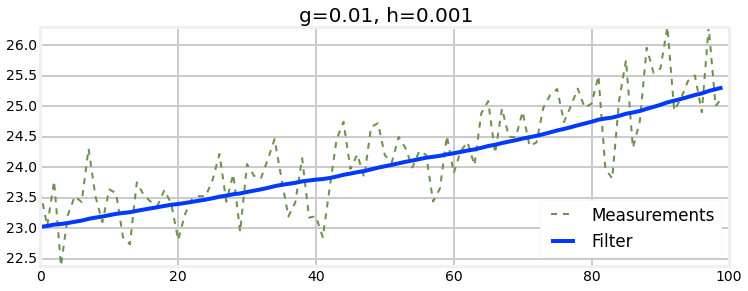

In [40]:
zs = gen_train_data_with_acc(23000, 15, 100)
data = g_h_filter(data=zs, x0=23000, dx=15., dt=1., g=.01, h=0.001)
plot_g_h_results(zs/1000, data/1000, 'g=0.01, h=0.001', z_label='Measurements')

There are two lessons to be learned here. First, use the *h* term to respond to changes in velocity that you are not modeling. But, far more importantly, there is a trade off here between responding quickly and accurately to changes in behavior and producing ideal output for when the system is in a steady state that you have. If the train never changes velocity we would make *h* extremely small to avoid having the filtered estimate unduly affected by the noise in the measurement. But in an interesting problem there is almost always changes in state, and we want to react to them quickly. The more quickly we react to it, the more we are affected by the noise in the sensors. 

I could go on, but my aim is not to develop g-h filter theory here so much as to build insight into how combining measurements and predictions lead to a filtered solution, so I will stop here. Do understand that there is extensive literature on choosing *g* and *h* for problems such as this, and that there are optimal ways of choosing them to achieve various goals. In the subsequent chapters we will learn how the Kalman filter solves this problem in the same basic manner, but with far more sophisticated mathematics. 

## g-h Filters with FilterPy

## Final Thoughts

*author's note*: the following few paragraphs really belong in the not yet written least squares chapter.

Near the beginning of the chapter I used `numpy.polyfit()` to fit a straight line to the weight measurements. It fits a n-th degree polynomial to the data using a 'least squared fit'. How does this differ from the g-h filter?

Well, it depends. We will eventually learn that the Kalman filter is optimal from a least squared fit perspective under certain conditions. However, `polyfit()` fits a polynomial to the data, not an arbitrary curve, by minimizing the value of this formula:
$$E = \sum_{j=0}^k |p(x_j) - y_j|^2$$

I assumed that my weight gain was constant at 1 lb/day, and so when I tried to fit a polynomial of $n=1$, which is a line, the result very closely matched the actual weight gain. But, of course, no one consistently only gains or loses weight. We fluctuate. Using 'polyfit()' for a longer series of data would yield poor results. In contrast, the g-h filter reacts to changes in the rate - the $h$ term controls how quickly  the filter reacts to these changes. If we gain weight, hold steady for awhile, then lose weight, the filter will track that change automatically. 'polyfit()' would not be able to do that unless the gain and loss could be well represented by a polynomial.

Another advantage of this form of filter, even if the data fits a *n*-degree polynomial, is that it is *recursive*. That is, we can compute the estimate for this time period knowing nothing more than the estimate and rate from the last time period. In contrast, if you dig into the implementation for `polyfit()` you will see that it needs all of the data before it can produce an answer. Therefore algorithms like `polyfit()` are not well suited for real-time data filtering. In the 60's when the Kalman filter was developed computers were very slow and had extremely limited memory. They were utterly unable to store, for example, thousands of readings from an aircraft's inertial navigation system, nor could they process all of that data in the short period of time needed to provide accurate and up-to-date navigation information. 


Up until the mid 20th century various forms of Least Squares Estimation was used for this type of filtering. For example, for NASA's Apollo program had a ground network for tracking the Command and Service Model (CSM) and the Lunar Module (LM). They took measurements over many minutes, batched the data together, and slowly computed an answer. In 1960 Stanley Schmidt at NASA Ames recognized the utility of Rudolf Kalman's seminal paper and invited him to Ames. Schmidt applied Kalman's work to the on board navigation systems on the CSM and LM, and called it the "Kalman filter".[1] Soon after, the world moved to this faster, recursive filter.

The Kalman filter only needs to store the last estimate and a few related parameters, and requires only a relatively small number of computations to generate the next estimate. Today we have so much memory and processing power that this advantage is somewhat less important, but at the time the Kalman filter was a major breakthrough not just because of the mathematical properties, but because it could (barely) run on the hardware of the day. 

This subject is much deeper than this short discussion suggests. We will consider these topics many more times throughout the book.

## Summary

I encourage you to experiment with this filter to develop your understanding of how it reacts. It shouldn't take too many attempts to come to the realization that ad-hoc choices for $g$ and $h$ do not perform very well. A particular choice might perform well in one situation, but very poorly in another. Even when you understand the effect of $g$ and $h$ it can be difficult to choose proper values. In fact, it is extremely unlikely that you will choose values for $g$ and $h$ that is optimal for any given problem. Filters are *designed*, not selected *ad hoc*. 

In some ways I do not want to end the chapter here, as there is a significant amount that we can say about selecting $g$ and $h$. But the g-h filter in this form is not the purpose of this book. Designing the Kalman filter requires you to specify a number of parameters - indirectly they do relate to choosing $g$ and $h$, but you will never refer to them directly when designing Kalman filters. Furthermore, $g$ and $h$ will vary at every time step in a very non-obvious manner. 

There is another feature of these filters we have barely touched upon - Bayesian statistics. You will note that the term 'Bayesian' is in the title of this book; this is not a coincidence! For the time being we will leave $g$ and $h$ behind, largely unexplored, and develop a very powerful form of probabilistic reasoning about filtering. Yet suddenly this same g-h filter algorithm will appear, this time with a formal mathematical edifice that allows us to create filters from multiple sensors, to accurately estimate the amount of error in our solution, and to control robots.

## References

*  [1] NASA Kalman Filtering Presentation<p> http://nescacademy.nasa.gov/review/downloadfile.php?file=FundamentalsofKalmanFiltering_Presentation.pdf&amp;id=199&amp;distr=Public


